# Reward Shaping

## 1. Imports

Importing various modules to the notebook including the local modules from the repository:
 - simulation environment,
 - the Evaluator (to evaluate stowage Plans),
 - algorithms (specially to find the inversion number)
 - pandas (for statistics)
 - matplotlib and seaborn for visualisations

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import time


from env import roroDeck
from analysis import *
from algorithms.Algorithms import calculate_degree_of_sort
from valuation import evaluator as evm
from valuation import evaluation

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

#set output path for plots
module_path = str(os.getcwd())+'\\out\\'
os.makedirs(module_path, exist_ok=True)

sns.set(style="whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})
plt.tight_layout()

## 2. RewardShaping

### 2.1 Create a meshgrid

Method to create a set of 

In [2]:
# This creates a set of all combinations of w in given ranges
def makeMeshGrid(w_mandatory_cargo,w_shifts,w_terminal_space, w_terminal_mand):
    systems = np.array(np.meshgrid(w_mandatory_cargo, w_shifts, w_terminal_space, w_terminal_mand)).T.reshape(-1, 4)
    
    return systems

### 2.2  Method to calculate 'Degree of Sort'

The method `calculate_scores` calculates the "degree of Sort" as outlined in the thesis for a set of random stowage plan for a given grid (`systems`). 

Method to determine the degree of Sort.

In [3]:
#Loop over all combinations of w
def calculate_scores(systems,n_stowage_plans,lanes=None, rows=None, time_info=True):
    start_time = time.time()

    all_observations = []
    system_reward = []
    for systemid in tqdm(range(len(systems)),leave=None):
        system = systems[systemid]

        cumulative_Rewards = np.zeros(n_stowage_plans)
        evaluations = []
        
        
        if lanes is not None and rows is not None:
            env = roroDeck.RoRoDeck(True, lanes=lanes, rows=rows)
        else:
            env = roroDeck.RoRoDeck(True)
            
            
            
        env.reward_system = system
        evaluator = evm.Evaluator(env.vehicle_data,env.grid)

        unique_cumulRewards = set()
        unique_eval = set()
        
        # Create random stowage plans
        for i in range(n_stowage_plans):
            total_Reward = 0
            env.reset()
            done = False

            while not done:
                action = env.action_space_sample()
                observation_, reward, done, info = env.step(action)
                total_Reward += reward

            stowagePlan = env.get_stowage_plan()
            evaluation = evaluator.evaluate(stowagePlan)

            cumulative_Rewards[i] = total_Reward
            if total_Reward not in unique_cumulRewards and \
                            evaluation not in unique_eval and \
                            evaluation.mandatory_cargo_loaded > 0.9:
                evaluations += [(total_Reward,evaluation)]


            unique_eval.add(evaluation)
            unique_cumulRewards.add(total_Reward)

        #Sort to Cumulative Reward
        evaluations.sort(key=lambda tup:tup[0])
        #Mark this Sequence
        sorted_cumul_Rewards = []
        for ix,a in enumerate(evaluations):
            sorted_cumul_Rewards += [(ix,a[0],a[1])]

        #Sort to true Evaluation
        #An ideal reward system will have a perfectly sorted marked sequence
        sorted_cumul_Rewards.sort(key=lambda tup: tup[2])

        rewardSystemEval = np.array([i[0] for i in sorted_cumul_Rewards])

        #Calculate absolute inversion numver (not needed) and the degree of the sort
        try:
            invNumber,degree = calculate_degree_of_sort(rewardSystemEval)
        except:
            degree = -1

        obs = np.append(system,np.array(degree))

        all_observations += [obs]
        
        df = pd.DataFrame(np.array(all_observations))
        df = df.rename(columns={0: "Mandatory Cargo", 1: "caused Shifts in %", 2: "unused Space",
                               3: "unloaded mandatory cargo", 4: "Degree of Sort"})
        
        system_reward += (system,sorted_cumul_Rewards)
    
    end_time = time.time() -start_time
    if time_info:
        print('Time passed: ',str(int(end_time/60)),' min ',str(round(end_time%60,2)),' sec')
    
    return df, system_reward

Since the method `calculate_scores` is quite time intensive a nested gridsearch is executed. Firstly the realm of potential systems is identified by performing gridsearch over with a step size of 5. In a second step the grid search with the adjusted range for each variable and a smaller grid length.

In [4]:
# for reproducibility a random seed is set
np.random.seed(0)

In [5]:
range_mandatory_cargo = np.arange(-2, 20, 2)
range_shifts = np.arange(-40, 0, 2)
range_terminalSpace = np.arange(-21, 5, 2)
range_terminalMand = np.arange(-60, -30, 2)

#range_mandatory_cargo = np.arange(-2, 20, 4)
#range_shifts = np.arange(-40, 0, 4)
#range_terminalSpace = np.arange(-19, 5, 4)
#range_terminalMand = np.arange(-60, -30, 4)


systems = makeMeshGrid(range_mandatory_cargo,range_shifts,
                       range_terminalSpace,range_terminalMand)

#Set how many stowage plans should be evaluated for one combination of w
#(the results should be more robust if this number is higher)
number_stowage_plans = 40

To get an overview on the structure of the resulting set of all combinations of $\vec{w}$. The first few combinations are shown (each row is one vector $\vec{w}_i$, the coloumns represent the elements of this vector i.e. $w_{ij}$)

In [6]:
score_of_all_Combinations, all_evaluations = calculate_scores(systems,number_stowage_plans, lanes=10,rows=14,time_info=True)


Time passed:  212  min  18.5  sec


In [15]:
df_bestScores = score_of_all_Combinations[score_of_all_Combinations['Degree of Sort']
                                          >score_of_all_Combinations['Degree of Sort'].max()*0.95]

<Figure size 432x288 with 0 Axes>

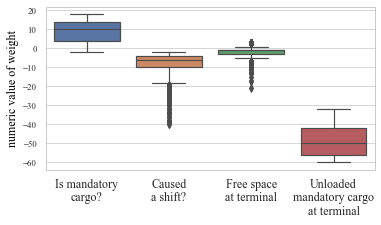

In [16]:
sns.despine(left=True)
sns.set_context("paper")
#plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})

#plt.tight_layout()

#print(df_bestScores[['Loading','caused Shifts','unused Space','unloaded mandatory cargo']])

fig = plt.figure(figsize=(5.9, 3.))


x_labels = ['Is mandatory\ncargo?','Caused\na shift?',
            'Free space\nat terminal','Unloaded\nmandatory cargo\nat terminal']

#plt.xlabel(fontsize=12)
ax = sns.boxplot(data = df_bestScores[['Mandatory Cargo','caused Shifts in %','unused Space','unloaded mandatory cargo']],
                palette="deep")


#ax.set_title("Boxplots of weights (only " +
#          "systems with a D(F) = {}%)".format(round(100*score_of_all_Combinations['Degree of Sort'].max()),2), fontsize=12)

plt.ylabel("numeric value of weight", fontsize=12)

ax.set_xticklabels(x_labels, fontsize=12)
#fig.autofmt_xdate()
#save locally
plt.savefig(module_path + '20201029MacrosearchL10R14.pdf', dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
heater = score_of_all_Combinations[score_of_all_Combinations['unused Space']==-1]
heater = heater[heater['unloaded mandatory cargo']==-50]

heater.head()

In [ ]:
df_bestScores

#score_of_all_Combinations[score_of_all_Combinations['Degree of Sort'] == 
#                          score_of_all_Combinations['Degree of Sort'].max()]
#score_of_all_Combinations.T[272]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(6.5, 3.5))

#fig = plt.figure(figsize=(3.5, 3.5))

heater1 = score_of_all_Combinations[score_of_all_Combinations['caused Shifts in %']==-12]
heater1 = heater1[heater1['unused Space']==-1]

heater2 = score_of_all_Combinations[score_of_all_Combinations['unused Space']==-1]
heater2 = heater2[heater2['unloaded mandatory cargo']==-50]

heat1 = heater1.pivot('Mandatory Cargo', 'unloaded mandatory cargo', 'Degree of Sort')
heat2 = heater2.pivot('Mandatory Cargo', 'caused Shifts in %', 'Degree of Sort')


vmin = min(heat1.values.min(), heat2.values.min())
vmax = max(heat1.values.max(), heat2.values.max())



#plt.title("HeatMap of weights (fixed weights: Loading : 0, unused Space: -1" +
#          "systems with a D(F) {}%)".format(round(100*df2['Degree of Sort'].max()),2))
sns.heatmap(heat1, ax =ax1, cbar=False, vmin=vmin)

sns.heatmap(heat2, ax =ax2, vmax=vmax)

ax2.set_ylabel('')    

#save locally
fig.autofmt_xdate()

plt.savefig(module_path + '29102020HeatMapL10R14.pdf')


In [ ]:
label_names =list(score_of_all_Combinations)

print(label_names)

numberOfStowagePlans = 100

lanes_comb = [8,10,12]
rows_comb = [11,12,13,14,15,16]
#env = roroDeck.RoRoDeck()
#print(env.lanes)
#print(env.rows)
#print(np.sum(env.total_capacity))
#score_of_all_Combinations[score_of_all_Combinations['Degree of Sort']==1]



In [ ]:
new_systems = np.array([[2., -8., -0.5, -50],
                        [2, -12., -1., -50.],
                        [-5., -20., -35., -50.]])
#routine to create labels
labels = []
for system in new_systems:
    string = '['
    for element in system:
        string += str(element)
        if not element == system[-1]:
            string += '\t'
    string += ']'        
    labels += [string]

df_best_systems = pd.DataFrame()
ax = None

for system in tqdm(new_systems, desc='Calculated Systems'):
    labels += [system]
    lanes_comb = [10,12,14,16]
    rows_comb = [12,14,16,20,24]
    df_different_sizes = pd.DataFrame(columns=label_names)
    capacities = set()
    for lane in lanes_comb:
        for row in rows_comb:
            if row > lane:
                capacity_value = np.sum(roroDeck.RoRoDeck(lanes=lane ,rows = row).total_capacity)
                #prevent duplicate values
                if capacity_value in capacities:
                    break
                else:
                    capacities.add(capacity_value)
                capacity = pd.DataFrame({'Capacity': [ capacity_value]})
                a, _ = calculate_scores([system], numberOfStowagePlans,
                                        lanes = lane, rows=row, time_info=False)
                a = a.join(capacity,sort=True)
                df_different_sizes = df_different_sizes.append(a, ignore_index = True, sort=True)
    if ax is None:
        ax = sns.lineplot(x='Capacity', y="Degree of Sort",
                 data=df_different_sizes)
    else:
        ax = sns.lineplot(x='Capacity', y="Degree of Sort",
                 data=df_different_sizes, ax=ax)

ax.legend(labels,loc='lower right')
#plt.savefig(module_path + 'CapacityConstency.pdf', dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
sns.pairplot(score_of_all_Combinations[score_of_all_Combinations['Degree of Sort']>=0.96])

### 2.3 Reduction of search space

From the previous result the areas to search for a vector $\vec{w}$ is reduced.

In [ ]:
range_mandatory_cargo = np.arange(0, 15, 1)
range_shifts = np.arange(-15, -5,1)
range_terminalSpace = np.arange(-5, 0, 1)
range_terminalMand = np.arange(-60, -30, 5)

systems_reduced = makeMeshGrid(range_mandatory_cargo,range_shifts,
                       range_terminalSpace,range_terminalMand)

#Set how many stowage plans should be evaluated for one combination of w
#(the results should be more robust if this number is higher)
number_stowage_plans = 100

In [ ]:
score_of_all_Combinations_micro, _ = calculate_scores(systems_reduced,number_stowage_plans, lanes=8,rows=14)

In [ ]:
df_bestScores_micro = score_of_all_Combinations_micro[score_of_all_Combinations_micro['Degree of Sort']
                                          >score_of_all_Combinations_micro['Degree of Sort'].max()*0.90]

In [ ]:
sns.despine(left=True)
sns.set_context("paper")
#plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})

#plt.tight_layout()

#print(df_bestScores[['Loading','caused Shifts','unused Space','unloaded mandatory cargo']])

fig = plt.figure(figsize=(5.9, 3.4))


x_labels = ['Is mandatory\ncargo?','Caused\na shift?',
            'Free space\nat terminal','Unloaded\nmandatory cargo\nat terminal']

#plt.xlabel(fontsize=12)
ax = sns.boxplot(data = df_bestScores_micro[['Mandatory Cargo','caused Shifts in %','unused Space','unloaded mandatory cargo']],
                palette="deep")


#ax.set_title("Boxplots of weights (only " +
#          "systems with a D(F) = {}%)".format(round(100*score_of_all_Combinations['Degree of Sort'].max()),2), fontsize=12)

plt.ylabel("numeric value of weight", fontsize=12)

ax.set_xticklabels(x_labels, fontsize=12)
#fig.autofmt_xdate()
#save locally
#plt.savefig(module_path + '20201029MicrosearchL08R14.pdf', dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
sns.pairplot(score_of_all_Combinations_micro[score_of_all_Combinations_micro['Degree of Sort']>=0.96])

In [ ]:
fig = plt.figure(figsize=(3.5, 3.5))
#plt.title("HeatMap of weights (fixed weights: Loading : 0, unused Space: -1" +
#          "systems with a D(F) {}%)".format(round(100*df2['Degree of Sort'].max()),2))
heat = heater.pivot('caused Shifts in %', 'unloaded mandatory cargo', 'Degree of Sort')
sns.heatmap(heat)

#save locally
fig.autofmt_xdate()

#plt.savefig(module_path + 'HeatMap.pdf')


In [ ]:
fig = plt.figure(figsize=(5.9, 3.5))
#plt.title("HeatMap of weights (fixed weights: Loading : 0, unused Space: -1" +
#          "systems with a D(F) {}%)".format(round(100*df2['Degree of Sort'].max()),2))
heat = heater.pivot('caused Shifts in %', 'unloaded mandatory cargo', 'Degree of Sort')
sns.kdeplot(heat)

#save locally
fig.autofmt_xdate()

plt.savefig(module_path + 'KDE.pdf')


In [ ]:
q25_Loading = df_bestScores[label_names[0]].quantile(0.25)
q75_Loading = df_bestScores[label_names[0]].quantile(0.75)

q25_Shifts = df_bestScores[label_names[1]].quantile(0.25)
q75_Shifts = df_bestScores[label_names[1]].quantile(0.75)

q25_terminalSpace = df_bestScores[label_names[2]].quantile(0.25)
q75_terminalSpace = df_bestScores[label_names[2]].quantile(0.75)

q25_terminalMand = df_bestScores[label_names[3]].quantile(0.25)
q75_terminalMand = df_bestScores[label_names[3]].quantile(0.75)

print(df_bestScores)

In [ ]:
df_test = pd.DataFrame(systems).head()

Thus the reward system implemented in this thesis is $\vec{w} = \Big[2 \ \ \ -12\ \ \  -1\ \ \  -50\Big]$

In [ ]:
b = 4447

rewards_semi_ordered_b = [y[1] for y in all_evaluations[b*2+1]]
rewards_semi_ordered_b = (rewards_semi_ordered_b - np.min(rewards_semi_ordered_b)) \
                        /(np.max(rewards_semi_ordered_b)-np.min(rewards_semi_ordered_b))

diff_b = np.diff(rewards_semi_ordered_b)

fig, axs = plt.subplots(2, sharex=True, figsize=(2.6, 4))
plt.setp(axs[0].get_xticklabels(), visible=True)

axs[0].plot(rewards_semi_ordered_b)
axs[0].set_title('Rewards of ordered ESP')

axs[1].stem(diff_b, use_line_collection=True)
axs[1].set(xlabel='ordered ESP')
fig.savefig(module_path + 'RewardSystem_b.pdf', dpi=600, bbox_inches="tight")
plt.show()



In [ ]:
a = 272

rewards_semi_ordered_a = [y[1] for y in all_evaluations[a*2+1]]
rewards_semi_ordered_a = (rewards_semi_ordered_a - np.min(rewards_semi_ordered_a)) \
                        /(np.max(rewards_semi_ordered_a)-np.min(rewards_semi_ordered_a))

diff_a = np.diff(rewards_semi_ordered_a)

#figsize=(5.9, 3.5)

fig, axs = plt.subplots(2, sharex=True, figsize=(2.6, 4))
plt.setp(axs[0].get_xticklabels(), visible=True)

axs[0].plot(rewards_semi_ordered_a)
axs[0].set_title('Rewards of ordered ESP')
axs[0].set(ylabel='reward\n(normalised)')

axs[1].stem(diff_a, use_line_collection=True)
axs[1].set(xlabel='ordered ESP', ylabel='reward difference\nof ordered ESP')
axs[1].set(xlabel='ordered ESP')
fig.savefig(module_path + 'RewardSystem_a.pdf', dpi=600, bbox_inches="tight")
plt.show()


In [ ]:
#TODO delete [0]
score_of_all_Combinations_micro

df2_bestScores = score_of_all_Combinations_micro[score_of_all_Combinations_micro['Degree of Sort']
                                          ==score_of_all_Combinations_micro['Degree of Sort'].max()]

In [ ]:
fig = plt.figure(figsize=(5.9, 3.8))


x_labels = ['Loading','number of\nShifts','Space\nutilisation', 'mandatory\ncargo']

#plt.xlabel(fontsize=12)
ax = sns.boxplot(data = df2_bestScores[['Mandatory Cargo','caused Shifts in %','unused Space','unloaded mandatory cargo']],
                palette="deep")


ax.set_title("Boxplots of weights (only " +
          "systems with a D(F) = {}%)".format(round(100*score_of_all_Combinations['Degree of Sort'].max()),2), fontsize=12)

plt.ylabel("numeric value of weight", fontsize=12)
ax.set_xticklabels(x_labels, fontsize=12)
#fig.autofmt_xdate()
#save locally
plt.savefig(module_path + '20201007Miccrosearch.pdf', dpi=600, bbox_inches="tight")

plt.show()

In [ ]:
df2_bestScores

In [ ]:
heater = heater[['caused Shifts in %','unloaded mandatory cargo','Degree of Sort']]

In [ ]:
#TODO statt heat map correlations graph

In [ ]:
#Private stuff

#score_of_all_Combinations[score_of_all_Combinations['Degree of Sort']==score_of_all_Combinations['Degree of Sort'].quantile(1)]

In [ ]:
a = 2034
a = 853

rewards_semi_ordered_a = [y[1] for y in all_evaluations[a*2+1]]
rewards_semi_ordered_a = (rewards_semi_ordered_a - np.min(rewards_semi_ordered_a)) \
                        /(np.max(rewards_semi_ordered_a)-np.min(rewards_semi_ordered_a))

diff_a = np.diff(rewards_semi_ordered_a)

#figsize=(5.9, 3.5)

fig, axs = plt.subplots(2, sharex=True, figsize=(2.6, 4))
plt.setp(axs[0].get_xticklabels(), visible=True)

axs[0].plot(rewards_semi_ordered_a)
axs[0].set_title('Rewards of ordered ESP')
#axs[0].set(ylabel='reward\n(normalised)')

axs[1].stem(diff_a, use_line_collection=True)
#axs[1].set(xlabel='ordered ESP', ylabel='reward difference\nof ordered ESP')
axs[1].set(xlabel='ordered ESP')
fig.savefig(module_path + 'RewardSystem_b.pdf', dpi=600, bbox_inches="tight")
plt.show()


In [ ]:
numberOfStowagePlans = 20
score_of_all_Combinations_micro, _ = calculateScore(np.array(df2_bestScores.drop(['Degree of Sort'], axis=1)),
                                                    numberOfStowagePlans, lanes = 12, rows=20)

25